<a href="https://colab.research.google.com/github/micah-shull/pipelines/blob/main/pipelines_1704_feature_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Feature Extraction Methods

In addition to the methods you mentioned (PCA, Factor Analysis, target encoding, and frequency encoding), here are a few additional techniques for feature extraction that can be beneficial:

1. **Principal Component Analysis (PCA):**
   - Reduces the dimensionality of numerical data by projecting it onto a lower-dimensional subspace that captures the maximum variance in the data.

2. **Factor Analysis:**
   - Identifies latent variables that explain the patterns of correlations within a set of observed variables.

3. **Target Encoding:**
   - Replaces categorical values with the mean of the target variable for each category.

4. **Frequency Encoding:**
   - Replaces categorical values with their frequency counts.

5. **Polynomial Features:**
   - Generates new features by taking polynomial combinations of the existing features.

6. **Interactions:**
   - Creates new features by multiplying existing features together to capture interaction effects.

7. **Truncated SVD:**
   - Similar to PCA but works with sparse matrices, often used in text data (Latent Semantic Analysis).

8. **Clustering-based Features:**
   - Uses clustering algorithms (like K-Means) to create new features representing the distance to cluster centroids or cluster memberships.

9. **Embedding Techniques:**
   - Uses algorithms like Word2Vec or embeddings from deep learning models to represent categorical variables as dense vectors.

10. **Autoencoders:**
    - Uses neural networks to learn compressed representations of the data.



##Load & Preprocess



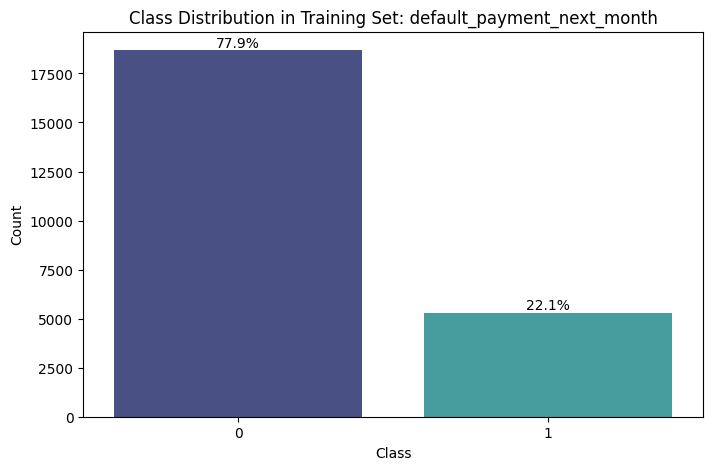

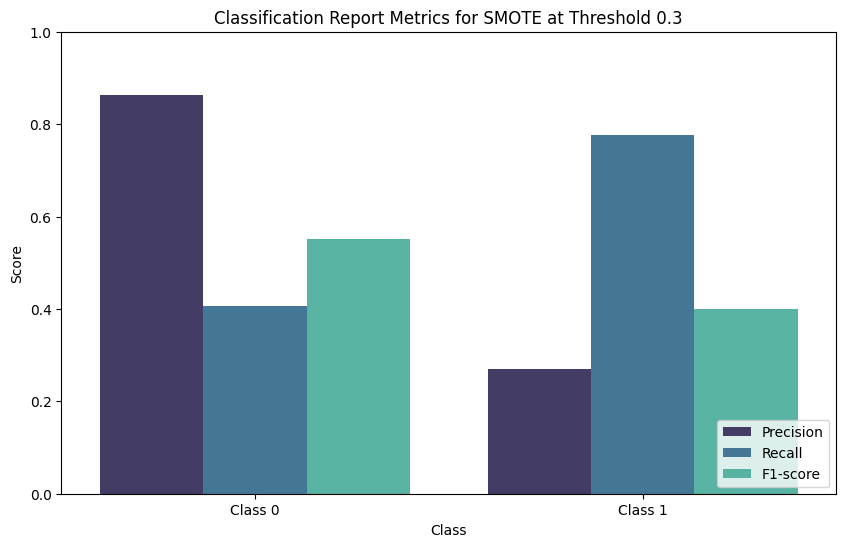

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.base import BaseEstimator, TransformerMixin
import json
import warnings
from loan_data_utils import load_and_preprocess_data, plot_class_distribution, plot_classification_report_metrics

# Suppress warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Define your URL, categorical columns, and target
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls"
categorical_columns = ['sex', 'education', 'marriage']
target = 'default_payment_next_month'

# Load and preprocess data
X, y = load_and_preprocess_data(url, categorical_columns, target)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Identify numeric and categorical columns
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['category']).columns.tolist()

# Define the column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), numeric_features),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OneHotEncoder(drop='first'))
        ]), categorical_features)
    ])

# Define a custom classifier to handle class-specific threshold
class ThresholdClassifier(BaseEstimator, TransformerMixin):
    def __init__(self, base_classifier, threshold=0.5):
        self.base_classifier = base_classifier
        self.threshold = threshold

    def fit(self, X, y):
        self.base_classifier.fit(X, y)
        return self

    def predict_proba(self, X):
        return self.base_classifier.predict_proba(X)

    def predict(self, X):
        proba = self.predict_proba(X)
        return (proba[:, 1] >= self.threshold).astype(int)

# Apply SMOTE and then the preprocessing pipeline
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Use the custom classifier with Logistic Regression and a threshold of 0.3 for class 1
base_classifier = LogisticRegression(max_iter=3000)
classifier = ThresholdClassifier(base_classifier, threshold=0.3)

# ------- Plot Class Distribution & Predictions --------#

# Load the classification reports from the JSON file
with open('resampling_comparison_results.json', 'r') as f:
    results = json.load(f)

# Extract the classification report for SMOTE at threshold 0.3
smote_threshold_0_3_report = results['SMOTE']['Threshold 0.3']

# plot target distribution
plot_class_distribution(y_train, target)
# Plot the classification report metrics for SMOTE at threshold 0.3
plot_classification_report_metrics(smote_threshold_0_3_report, 'SMOTE', '0.3')

## Principal Component Analysis (PCA)
   - **Objective:** Reduce the dimensionality of numerical data by transforming the original features into a new set of orthogonal (uncorrelated) components that capture the maximum variance in the data.
   - **How it works:** PCA projects the data onto a lower-dimensional subspace using linear combinations of the original features, with the first few principal components explaining most of the variance.
   - **Benefits:** Reduces the number of features while retaining most of the information, helps in visualizing high-dimensional data, and can improve the performance and efficiency of machine learning algorithms.





In [23]:
from sklearn.decomposition import PCA

# Define the preprocessing pipeline with PCA
preprocessor_pca = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('scaler', StandardScaler()),
            ('pca', PCA(n_components=5))
        ]), numeric_features),
        ('cat', Pipeline(steps=[
            ('encoder', OneHotEncoder(drop='first'))
        ]), categorical_features)
    ])

pipeline_pca = Pipeline(steps=[
    ('preprocessor', preprocessor_pca),
    ('classifier', classifier)
])

pipeline_pca.fit(X_train_res, y_train_res)
y_pred_pca = pipeline_pca.predict(X_test)
classification_report_pca = classification_report(y_test, y_pred_pca, output_dict=True)
print("Classification Report (PCA):")
print(classification_report(y_test, y_pred_pca))

# Save the classification report
results = {}
try:
    with open('feature_extraction_reports.json', 'r') as f:
        results = json.load(f)
except FileNotFoundError:
    pass

results['PCA'] = classification_report_pca

with open('feature_extraction_reports.json', 'w') as f:
    json.dump(results, f, indent=4)


Classification Report (PCA):
              precision    recall  f1-score   support

           0       0.87      0.37      0.52      4673
           1       0.26      0.80      0.40      1327

    accuracy                           0.46      6000
   macro avg       0.57      0.58      0.46      6000
weighted avg       0.73      0.46      0.49      6000



### Factor Analysis
   - **Objective:** Identify latent variables (factors) that explain the observed correlations among a set of variables.
   - **How it works:** Factor Analysis models the data as linear combinations of latent factors and unique variances, aiming to explain the common variance shared among the variables.
   - **Benefits:** Useful for identifying underlying relationships between variables, reducing dimensionality, and improving interpretability by summarizing data with fewer factors.



In [26]:
from sklearn.decomposition import FactorAnalysis

# Define the preprocessing pipeline with Factor Analysis
preprocessor_fa = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('scaler', StandardScaler()),
            ('fa', FactorAnalysis(n_components=10))
        ]), numeric_features),
        ('cat', Pipeline(steps=[
            ('encoder', OneHotEncoder(drop='first'))
        ]), categorical_features)
    ])

pipeline_fa = Pipeline(steps=[
    ('preprocessor', preprocessor_fa),
    ('classifier', classifier)
])

pipeline_fa.fit(X_train_res, y_train_res)
y_pred_fa = pipeline_fa.predict(X_test)
classification_report_fa = classification_report(y_test, y_pred_fa, output_dict=True)
print("Classification Report (Factor Analysis):")
print(classification_report(y_test, y_pred_fa))

# Save the classification report
try:
    with open('feature_extraction_reports.json', 'r') as f:
        results = json.load(f)
except FileNotFoundError:
    pass

results['Factor Analysis'] = classification_report_fa

with open('feature_extraction_reports.json', 'w') as f:
    json.dump(results, f, indent=4)


/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_factor_analysis.py:297: ConvergenceWarning: FactorAnalysis did not converge. You might want to increase the number of iterations.
  warnings.warn(


Classification Report (Factor Analysis):
              precision    recall  f1-score   support

           0       0.86      0.39      0.53      4673
           1       0.27      0.78      0.40      1327

    accuracy                           0.47      6000
   macro avg       0.56      0.58      0.47      6000
weighted avg       0.73      0.47      0.50      6000



###Target Encoding
   - **Objective:** Encode categorical features by replacing each category with the mean of the target variable for that category.
   - **How it works:** For each category in a categorical feature, calculate the mean target value (e.g., the average probability of the target class) and use this mean as the encoded value.
   - **Benefits:** Captures the relationship between categorical features and the target variable, often resulting in improved model performance, especially in cases where categories have different levels of impact on the target.



In [8]:
# pip install category_encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 2.8 MB/s eta 0:00:00


In [16]:
import category_encoders as ce

# Define the preprocessing pipeline with target encoding
preprocessor_te = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('scaler', StandardScaler())
        ]), numeric_features),
        ('cat', Pipeline(steps=[
            ('target_encoder', ce.TargetEncoder())
        ]), categorical_features)
    ])

pipeline_te = Pipeline(steps=[
    ('preprocessor', preprocessor_te),
    ('classifier', classifier)
])

pipeline_te.fit(X_train_res, y_train_res)
y_pred_te = pipeline_te.predict(X_test)
classification_report_te = classification_report(y_test, y_pred_te, output_dict=True)
print("Classification Report (Target Encoding):")
print(classification_report(y_test, y_pred_te))

# Save the classification report
try:
    with open('feature_extraction_reports.json', 'r') as f:
        results = json.load(f)
except FileNotFoundError:
    pass

results['Target Encoding'] = classification_report_te

with open('feature_extraction_reports.json', 'w') as f:
    json.dump(results, f, indent=4)


Classification Report (Target Encoding):
              precision    recall  f1-score   support

           0       0.87      0.39      0.54      4673
           1       0.27      0.80      0.40      1327

    accuracy                           0.48      6000
   macro avg       0.57      0.59      0.47      6000
weighted avg       0.74      0.48      0.51      6000



### Polynomial Features
   - **Objective:** Create new features by generating polynomial combinations of the existing features, allowing the model to capture non-linear relationships.
   - **How it works:** Polynomial Features generates interaction terms and higher-degree terms (e.g., squares, cubes) for the original features, expanding the feature space.
   - **Benefits:** Enhances the model's ability to capture complex, non-linear relationships between features, potentially improving predictive performance.

In [24]:
from sklearn.preprocessing import PolynomialFeatures

# Define the preprocessing pipeline with polynomial features
preprocessor_poly = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('scaler', StandardScaler()),
            ('poly', PolynomialFeatures(degree=2))
        ]), numeric_features),
        ('cat', Pipeline(steps=[
            ('encoder', OneHotEncoder(drop='first'))
        ]), categorical_features)
    ])

pipeline_poly = Pipeline(steps=[
    ('preprocessor', preprocessor_poly),
    ('classifier', classifier)
])

pipeline_poly.fit(X_train_res, y_train_res)
y_pred_poly = pipeline_poly.predict(X_test)
classification_report_poly = classification_report(y_test, y_pred_poly, output_dict=True)
print("Classification Report (Polynomial Features):")
print(classification_report(y_test, y_pred_poly))

# Save the classification report
try:
    with open('feature_extraction_reports.json', 'r') as f:
        results = json.load(f)
except FileNotFoundError:
    pass

results['Polynomial Features'] = classification_report_poly

with open('feature_extraction_reports.json', 'w') as f:
    json.dump(results, f, indent=4)

Classification Report (Polynomial Features):
              precision    recall  f1-score   support

           0       0.88      0.45      0.59      4673
           1       0.29      0.78      0.42      1327

    accuracy                           0.52      6000
   macro avg       0.58      0.61      0.51      6000
weighted avg       0.75      0.52      0.55      6000



### Plot Results

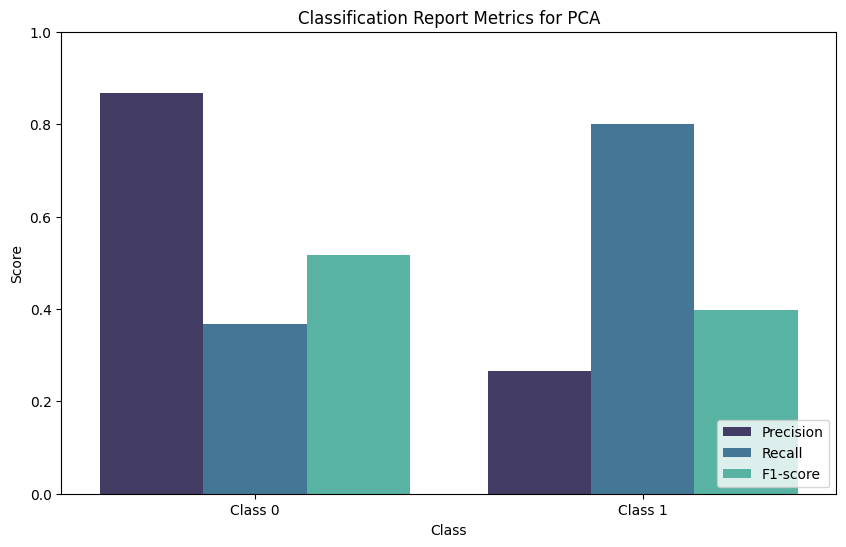

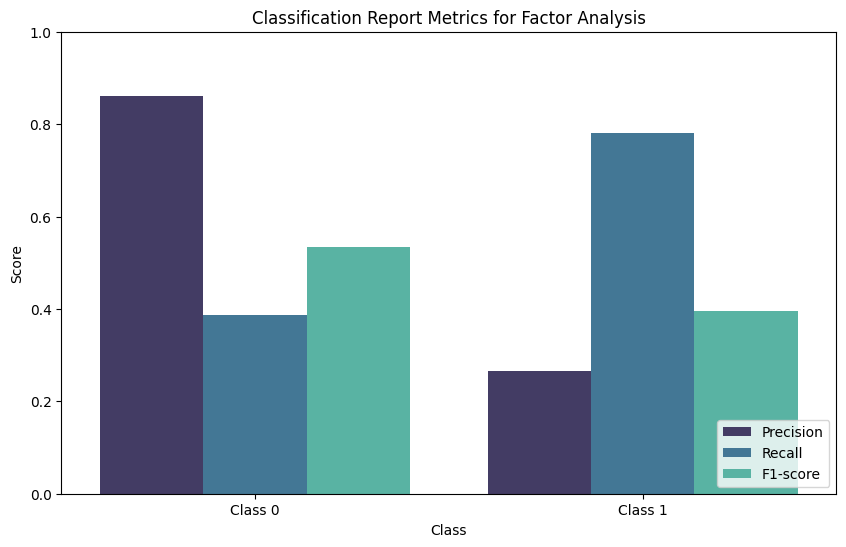

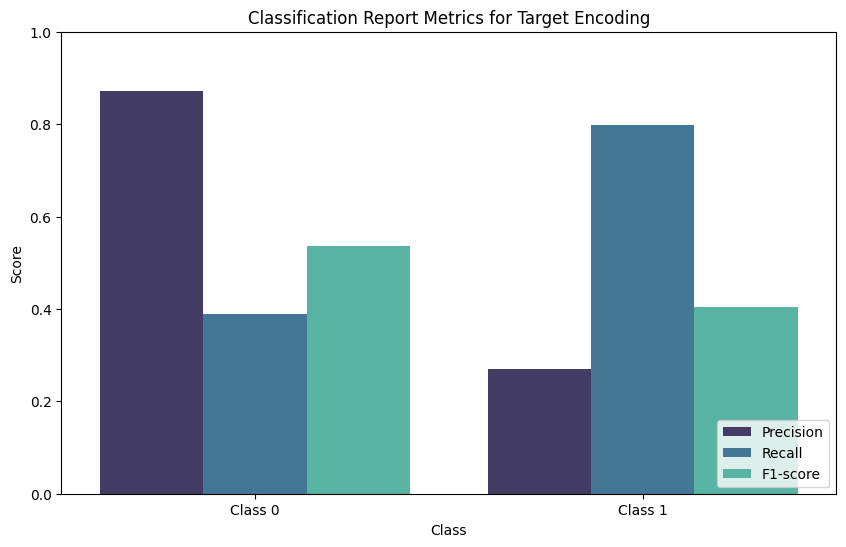

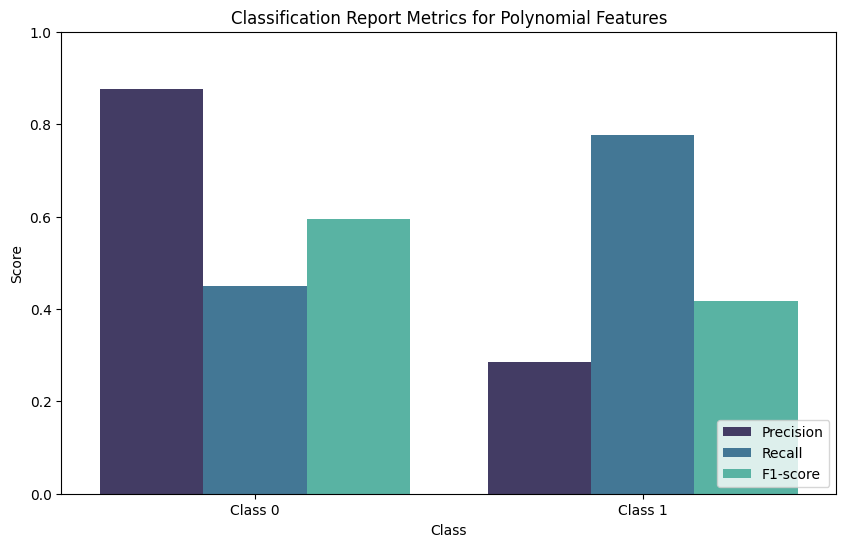

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json

def plot_classification_report_metrics(report, method_name):
    metrics_df = pd.DataFrame({
        'Class': ['Class 0', 'Class 0', 'Class 0', 'Class 1', 'Class 1', 'Class 1'],
        'Metric': ['Precision', 'Recall', 'F1-score', 'Precision', 'Recall', 'F1-score'],
        'Value': [
            report['0']['precision'],
            report['0']['recall'],
            report['0']['f1-score'],
            report['1']['precision'],
            report['1']['recall'],
            report['1']['f1-score']
        ]
    })

    plt.figure(figsize=(10, 6))
    sns.barplot(x='Class', y='Value', hue='Metric', data=metrics_df, palette='mako')
    plt.title(f'Classification Report Metrics for {method_name}')
    plt.ylabel('Score')
    plt.ylim(0, 1)
    plt.legend(loc='lower right')
    plt.show()

# Load and plot metrics for feature extraction methods
with open('feature_extraction_reports.json', 'r') as f:
    results = json.load(f)

for method, report in results.items():
    plot_classification_report_metrics(report, method)


#### Data Utils Script

In [1]:
script_content=r'''
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import joblib
import json
import logging
# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

#--------   Load and Preprocess Data   --------#

def load_data_from_url(url):
    try:
        df = pd.read_excel(url, header=1)
        logging.info("Data loaded successfully from URL.")
    except Exception as e:
        logging.error(f"Error loading data from URL: {e}")
        return None
    return df

def clean_column_names(df):
    df.columns = [col.lower().replace(' ', '_') for col in df.columns]
    return df

def remove_id_column(df):
    if 'id' in df.columns:
        df = df.drop(columns=['id'])
    return df

def rename_columns(df):
    rename_dict = {'pay_0': 'pay_1'}
    df = df.rename(columns=rename_dict)
    return df

def convert_categorical(df, categorical_columns):
    df[categorical_columns] = df[categorical_columns].astype('category')
    return df

def split_features_target(df, target):
    X = df.drop(columns=[target])
    y = df[target]
    return X, y

def load_and_preprocess_data(url, categorical_columns, target):
    df = load_data_from_url(url)
    if df is not None:
        df = clean_column_names(df)
        df = remove_id_column(df)
        df = rename_columns(df)
        df = convert_categorical(df, categorical_columns)
        X, y = split_features_target(df, target)
        return X, y
    return None, None

#--------   Plot Class Distribution   --------#


def plot_class_distribution(y_train, target_name):
    plt.figure(figsize=(8, 5))
    sns.countplot(x=y_train, hue=y_train, palette='mako')
    plt.title(f'Class Distribution in Training Set: {target_name}')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.legend([], [], frameon=False)

    # Calculate the percentage for each class
    total = len(y_train)
    class_counts = y_train.value_counts()
    for i, count in enumerate(class_counts):
        percentage = 100 * count / total
        plt.text(i, count, f'{percentage:.1f}%', ha='center', va='bottom')

    plt.show()

#--------   Plot Classification Report Metrics   --------#

def plot_classification_report_metrics(report, method_name, threshold):
    """
    Function to plot the precision, recall, and f1-score metrics for class 0 and class 1.
    """
    # Extract metrics from the report
    metrics_df = pd.DataFrame({
        'Class': ['Class 0', 'Class 0', 'Class 0', 'Class 1', 'Class 1', 'Class 1'],
        'Metric': ['Precision', 'Recall', 'F1-score', 'Precision', 'Recall', 'F1-score'],
        'Value': [
            report['0']['precision'],
            report['0']['recall'],
            report['0']['f1-score'],
            report['1']['precision'],
            report['1']['recall'],
            report['1']['f1-score']
        ]
    })

    # Plot the metrics
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Class', y='Value', hue='Metric', data=metrics_df, palette='mako')
    plt.title(f'Classification Report Metrics for {method_name} at Threshold {threshold}')
    plt.ylabel('Score')
    plt.ylim(0, 1)
    plt.legend(loc='lower right')
    plt.show()




#--------   Evaluate and Capture Metrics   --------#

# Function to evaluate model
def evaluate_model(pipeline, X_train, X_test, y_train, y_test, model_name, experiment_name):
    logger.info(f"Training and evaluating model: {model_name} ({experiment_name})")

    # Fit the pipeline
    pipeline.fit(X_train, y_train)

    # Make predictions
    y_pred = pipeline.predict(X_test)

    # Capture classification report
    report = classification_report(y_test, y_pred, output_dict=True)

    # Extract relevant metrics
    metrics = {
        'Model': model_name,
        'Experiment': experiment_name,
        'Recall_0': report['0']['recall'],
        'Precision_0': report['0']['precision'],
        'F1_0': report['0']['f1-score'],
        'Recall_1': report['1']['recall'],
        'Precision_1': report['1']['precision'],
        'F1_1': report['1']['f1-score'],
        'F1_Macro': report['macro avg']['f1-score'],
        'Accuracy': report['accuracy']
    }
    return metrics


'''

# Write the script to a file
with open("loan_data_utils.py", "w") as file:
    file.write(script_content)

print("Script successfully written to loan_data_utils.py")
# Reload script to make functions available for use
import importlib
import loan_data_utils
importlib.reload(loan_data_utils)

from loan_data_utils import *

Script successfully written to loan_data_utils.py
